# Imports

In [1]:
import pandas as pd, numpy as np, yaml, os, seaborn as sns, hypercluster as hc, matplotlib.pyplot as plt, matplotlib
import sklearn, umap
from wand.image import Image as WImage
sns.set(style = 'white', color_codes=True, font_scale = 1.3)
matplotlib.rcParams.update({'savefig.bbox': 'tight', 'savefig.dpi': '500'})

# Read in data and make input tables

In [2]:
input_data_prefix = 'sc_data'
gold_standard_file = 'gold_standard.csv'

In [3]:
df = pd.read_csv('data_table_100genes.csv', index_col=0)
df = df[[col for col in df.columns if col != 'cluster']].transpose()
df.to_csv('%s.csv' % input_data_prefix)

In [4]:
df.shape

(970, 100)

In [108]:
labels = pd.DataFrame({'labels':[i.split('|', 1)[0].split('-')[1] for i in df.index]}, index=df.index)
labels.to_csv(gold_standard_file)

# Edit config

In [12]:
with open('../../config.yml', 'r') as fh:
    config = yaml.load(fh)

/gpfs/data/ruggleslab/home/lmb529/conda/envs/hypercluster/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [49]:
config['input_data_folder'] = os.path.abspath('.')
config['input_data_files'] = [input_data_prefix]
config['gold_standards'] = {input_data_prefix: gold_standard_file}
config['read_csv_kwargs'] = {input_data_prefix:{'index_col': [0]}}
config['evaluations'] = hc.constants.need_ground_truth + hc.constants.inherent_metrics
config['generate_parameters_addtl_kwargs'] = {'random_search': False}
config['make_sample_fig'] = False
nclusters = [i for i in range(2, 60)]
config['optimization_parameters']['KMeans'] = {'n_clusters':nclusters}
config['optimization_parameters']['MiniBatchKMeans'] = {'n_clusters':nclusters}

In [50]:
with open('config.yml', 'w') as fh:
    yaml.dump(config, stream=fh)

# Running snakemake

In [60]:
%%bash
module add slurm
mkdir -p logs
sbatch snakemake_submit.sh

Submitted batch job 5917955


 /gpfs/data/ruggleslab/home/lmb529/conda/bin


# Visualizing results

In [170]:
best_labels = pd.read_csv('sc_data/clustering/sc_data_labels.txt', index_col=0)
evals = pd.read_csv('sc_data/clustering/sc_data_evaluations.txt', index_col=0)
evals = evals[evals.columns[evals.loc['number_clustered', :] == evals.loc['number_clustered', :].max()]]
best_labels = evals.columns[evals.loc['adjusted_rand_score', :] == evals.loc['adjusted_rand_score', :].max()][0]

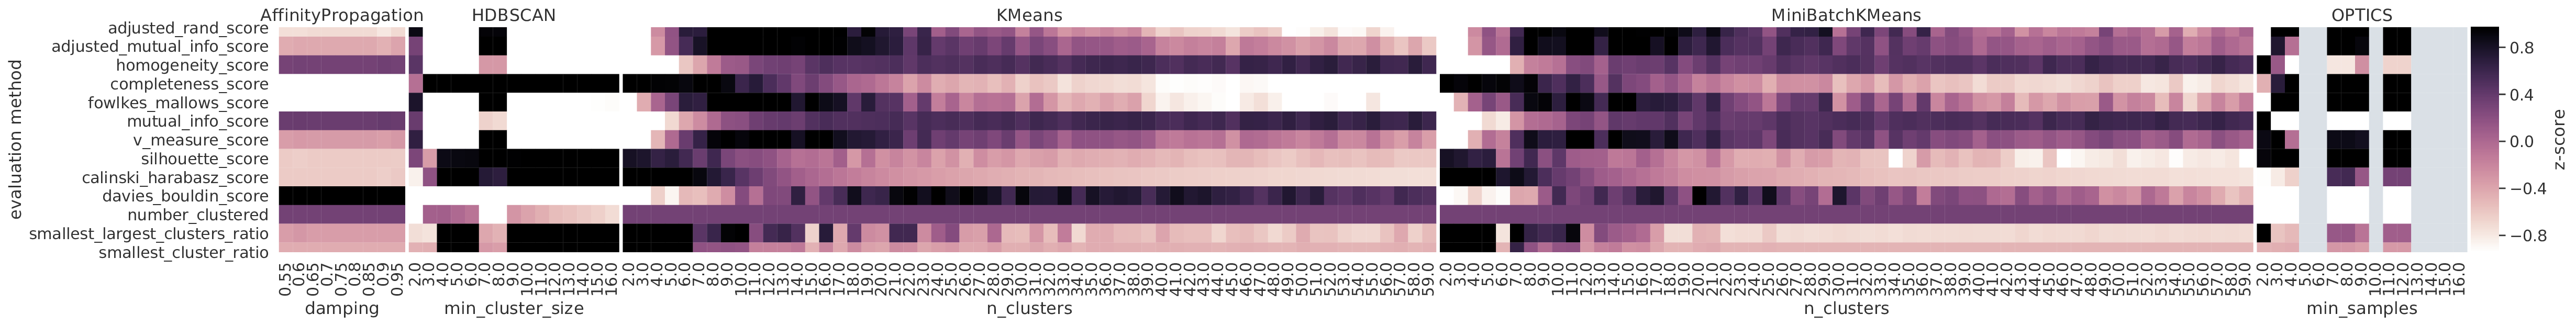

In [171]:
img = WImage(filename='sc_data/clustering/sc_data_evaluations.pdf', resolution=150)
img

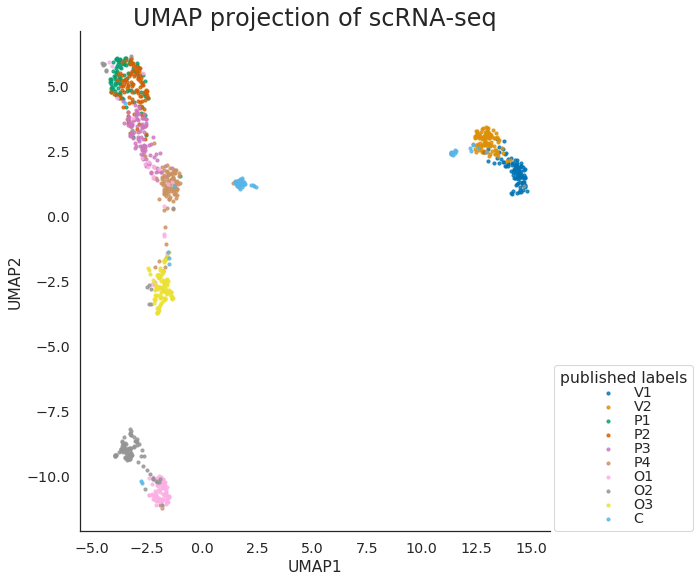

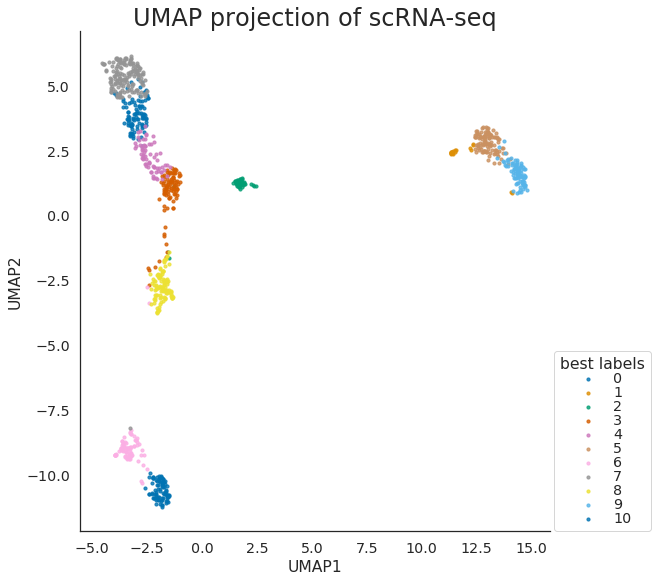

In [174]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(df)
embedding = pd.DataFrame(embedding, index=df.index, columns=['UMAP1', 'UMAP2'])
embedding['published_labels'] = labels.reindex(embedding.index)
embedding['best_labels'] = new_labels[best_labels].reindex(embedding.index)

for labs in ['published_labels', 'best_labels']:
    sns.lmplot('UMAP1','UMAP2', data = embedding, hue=labs, fit_reg=False, height=8, scatter_kws=dict(s=10), legend=False, palette='colorblind')
    plt.title('UMAP projection of scRNA-seq', fontsize=24)
    plt.legend(title=labs.replace('_', ' '), loc=(1.01, 0), labelspacing=0)
    plt.savefig('figures/umap.%s.pdf' % labs)

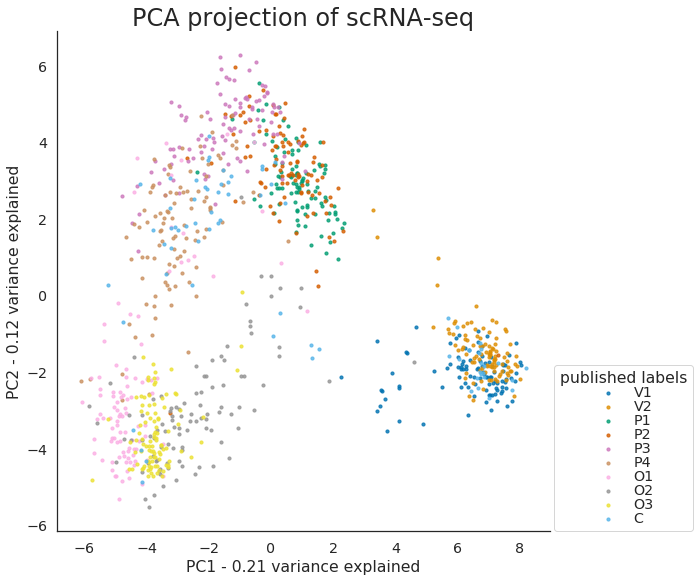

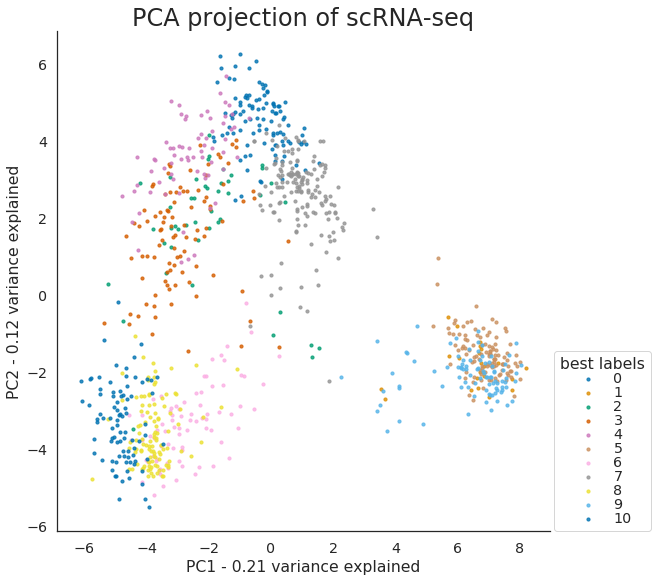

In [175]:
reducer = sklearn.decomposition.PCA(n_components=2)
embedding = reducer.fit_transform(df)
embedding = pd.DataFrame(embedding, index=df.index, columns=['PC1', 'PC2'])
embedding['published_labels'] = labels.reindex(embedding.index)
embedding['best_labels'] = new_labels[best_labels].reindex(embedding.index)

for labs in ['published_labels', 'best_labels']:
    sns.lmplot('PC1','PC2', data = embedding, hue=labs, fit_reg=False, height=8, scatter_kws=dict(s=10), legend=False, palette='colorblind')
    plt.xlabel('PC1 - %.2f variance explained' % reducer.explained_variance_ratio_[0])
    plt.ylabel('PC2 - %.2f variance explained' % reducer.explained_variance_ratio_[1])
    plt.title('PCA projection of scRNA-seq', fontsize=24)
    plt.legend(title=labs.replace('_', ' '), loc=(1.01, 0), labelspacing=0)
    plt.savefig('figures/pca.%s.pdf' % labs)